# Optimization for the Travelling Salesman problem (Christofides method)

#### Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

Travelling Salesman Problem (TSP) aims to find the optimal solution which has the minimal sum of visiting distances and contains only a single tour covering all cities. TSP is a NP-hard problem in combinatorial optimization. 

TSP solutions have been commonly applied to vehicle routing (e.g. what is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?) and other spatial analytics use cases.

#### Case study: What is the optimal tour to visit $n = 73$ Target Stores in Minnesota?

### Install required libraries

In [1]:
#!pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle as pkl
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import *
from src_import.christofides import *
from itertools import combinations 

from cartoframes import *
from cartoframes.data import Dataset
from cartoframes.viz import *

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import ipywidgets as widgets
from ipywidgets import Output, Tab
from IPython.display import clear_output

import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [4]:
with open('./data/target_mn_loc.p', 'rb') as f:
    target_mn_loc = pkl.load(f)

## The Christofides method:


```
1. Create a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T. 
3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in previous step into a Hamiltonian circuit (S) by skipping repeated vertices (shortcutting).
```

In [5]:
tests = [tsp([list(_[1])[::-1] for _ in target_mn_loc.items()]) for _ in range(100)]
tsp_result = tests[np.argmin([_[6] for _ in tests])]

## The solution

2019-08-11 10:03:17,595 - INFO - [Min] 2075.5577428288625;  [Max] 2654.350070689202


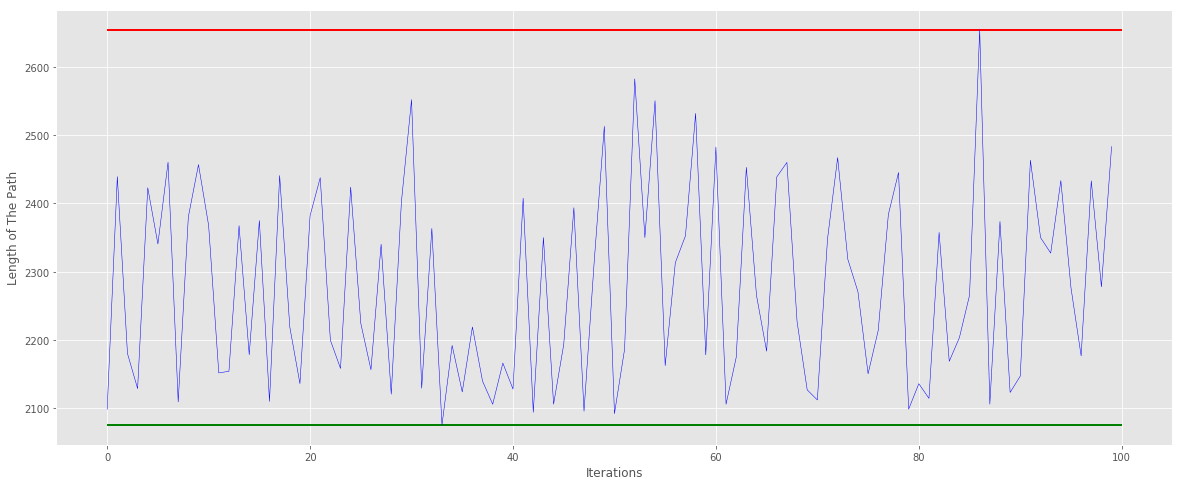

In [6]:
f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_[6] for _ in tests], color='blue', linewidth=0.5)
ax.hlines(y=min([_[6] for _ in tests]), xmin=0, xmax=100, color='green', linewidth=2)
ax.hlines(y=max([_[6] for _ in tests]), xmin=0, xmax=100, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

logging.info(f"[Min] {min([_[6] for _ in tests])};  [Max] {max([_[6] for _ in tests])}")

### 1. Complete Graph (G): $ \dfrac{n \, (n-1)}{2}$ possible edges

In [7]:
complete_graph = pd.DataFrame([LineString(_) for _ in combinations(list(target_mn_loc.values()), 2)], columns=['geometry'])
Map(Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.8)'}),
    basemap = basemaps.darkmatter)

### 2. Minimum Spanning Tree (T): subset of the edges that connect all the vertices togheter without any cycle and with the minumum possible total edge weight

In [8]:
minimum_spanning_tree = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[1]], columns=['geometry'])
Map(layers=[
    Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.5,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3})],
    basemap = basemaps.darkmatter)

### 3.1 Vertices with odd degree (O) i.e. vertices with an odd number of incident edges

In [9]:
vertices_odd_degree = pd.DataFrame([Point(list(target_mn_loc.values())[_]) for _ in tsp_result[2]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

### 3.2 Form the subgraph G' of G using only the vertices of O (G')

In [10]:
sub_complete_graph = pd.DataFrame([LineString(_) for _ in combinations([list(target_mn_loc.values())[i] for i in tsp_result[2]], 2)], columns=['geometry'])
Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.8,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

In [11]:
len(sub_complete_graph)

378

### 5. Minimum-Weight (perfect) matching M From G' (M)

- **Matching**:  set of edges without any common edges (the vertices should have degree of 0 or 1)
- **Perfect Matching**: every vertex of the graph is incident to exactly one edge of the matching

In [12]:
min_weight_perfect_matching = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[3]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.2)'}),
    Layer(source = Dataset.from_dataframe(min_weight_perfect_matching), 
          style = {'width': 3, 
                   'color': 'green'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    viewport = {'zoom': 8.21, 'lat': 44.967879, 'lng': -93.365291},
    basemap = basemaps.darkmatter)


### 6. Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H), i.e. H does not have multiple edges

In [13]:
united_eulerian_multigraph = pd.DataFrame([LineString((list(target_mn_loc.values())[_[0]], list(target_mn_loc.values())[_[1]])) for _ in tsp_result[4]], columns=['geometry'])

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.2)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'darkgreen'}),
    #Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
    #      style = {'width': 3,
    #               'color': 'opacity(#46aea0, 0.8)'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'yellow'})],
    basemap = basemaps.darkmatter)

### 7. Form the Eulerian Tour (E) of H, i.e. the circuit that visits each edge exactly once without repeating

In [14]:
euler_tour = pd.DataFrame([LineString((list(target_mn_loc.values())[tsp_result[5][i-1]], list(target_mn_loc.values())[tsp_result[5][i]])) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour['order'] = euler_tour.index + 1

euler_tour_origin = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[5][i-1]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_origin['order'] = euler_tour_origin.index + 1

euler_tour_dst = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[5][i]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_dst['order'] = euler_tour_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 3, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 3,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset.from_dataframe(euler_tour), 
          style = {'width': 3,
                   'color': 'opacity(orange, 0.8)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset.from_dataframe(euler_tour_origin), 
          style = {'width': 8,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(euler_tour_dst), 
          style = {'width': 8,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 7, 
                   'color': 'opacity(yellow, 0.1)'})],
    basemap = basemaps.darkmatter)

### 8. Form the Hamiltonian Tour (S) of H (also called shortcutting) by skipping repeated vertices

In [15]:
final_route = pd.DataFrame([LineString((list(target_mn_loc.values())[tsp_result[7][i-1]], list(target_mn_loc.values())[tsp_result[7][i]])) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_route['order'] = final_route.index + 1

final_tour_origin = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[7][i-1]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_tour_origin['order'] = final_tour_origin.index + 1

final_tour_dst = pd.DataFrame([Point(list(target_mn_loc.values())[tsp_result[7][i]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
final_tour_dst['order'] = final_tour_dst.index + 1

Map(layers=[
    Layer(source = Dataset.from_dataframe(vertices_odd_degree), 
          style = {'width': 1, 
                   'color': 'opacity(yellow, 0.1)'}),
    Layer(source = Dataset.from_dataframe(sub_complete_graph), 
          style = {'width': 0.3,
                   'color': 'opacity(red, 0.1)'}),
    Layer(source = Dataset.from_dataframe(united_eulerian_multigraph), 
          style = {'width': 1, 
                   'color': 'opacity(darkgreen, 0.1)'}),
    Layer(source = Dataset.from_dataframe(minimum_spanning_tree), 
          style = {'width': 1,
                   'color': 'opacity(#46aea0, 0.1)'}),
    Layer(source = Dataset.from_dataframe(euler_tour), 
          style = {'width': 1,
                   'color': 'opacity(orange, 0.1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),
    Layer(source = Dataset.from_dataframe(final_tour_origin), 
          style = {'width': 10,
                   'color': 'opacity(#882255, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(final_tour_dst), 
          style = {'width': 10,
                   'color': 'opacity(#88CCEE, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, 0.5))'}),
    Layer(source = Dataset.from_dataframe(final_route), 
          style = {'width': 3,
                   'color': 'opacity(red, 1)',
                   'filter': 'animation(linear($order, globalMin($order), globalMax($order)), 40, fade(0, hold))'}),],
    basemap = basemaps.darkmatter)
